In [102]:
import pyspark
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [103]:
pd.set_option('display.max_rows', 9999)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

In [104]:
spark = SparkSession.builder.master("local[2]").appName('car_accidents').getOrCreate()

In [105]:
df = spark.read.csv('C:/Users/a842488/OneDrive - Atos/Desktop/Project', inferSchema='True', header=True)
df = df.sample(0.1)

# Data Analysis

In [106]:
df.dtypes

[('ID', 'string'),
 ('Severity', 'int'),
 ('Start_Time', 'string'),
 ('End_Time', 'string'),
 ('Start_Lat', 'double'),
 ('Start_Lng', 'double'),
 ('End_Lat', 'double'),
 ('End_Lng', 'double'),
 ('Distance(mi)', 'double'),
 ('Description', 'string'),
 ('Number', 'double'),
 ('Street', 'string'),
 ('Side', 'string'),
 ('City', 'string'),
 ('County', 'string'),
 ('State', 'string'),
 ('Zipcode', 'string'),
 ('Country', 'string'),
 ('Timezone', 'string'),
 ('Airport_Code', 'string'),
 ('Weather_Timestamp', 'string'),
 ('Temperature(F)', 'double'),
 ('Wind_Chill(F)', 'double'),
 ('Humidity(%)', 'double'),
 ('Pressure(in)', 'double'),
 ('Visibility(mi)', 'double'),
 ('Wind_Direction', 'string'),
 ('Wind_Speed(mph)', 'double'),
 ('Precipitation(in)', 'double'),
 ('Weather_Condition', 'string'),
 ('Amenity', 'boolean'),
 ('Bump', 'boolean'),
 ('Crossing', 'boolean'),
 ('Give_Way', 'boolean'),
 ('Junction', 'boolean'),
 ('No_Exit', 'boolean'),
 ('Railway', 'boolean'),
 ('Roundabout', 'boolean')

In [107]:
df.limit(5).toPandas().head(5)

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-11,2,2016-02-08 15:43:50,2016-02-08 21:43:50,39.193,-84.477,39.196,-84.473,0.307,At OH-4/Paddock Rd/Exit 9 - Accident.,NaN,I-75 N,R,Cincinnati,Hamilton,OH,45216,US,US/Eastern,KLUK,2016-02-08 15:47:00,33.8,29.6,100.0,29.66,3.0,NNW,4.6,0.03,Light Snow,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
1,A-22,3,2016-02-08 21:30:31,2016-02-09 03:30:31,39.038,-84.592,39.035,-84.600,0.471,At I-275/Exit 185 - Accident.,NaN,I-75 S,R,Ft Mitchell,Kenton,KY,41017,US,US/Eastern,KCVG,2016-02-08 21:15:00,26.6,15.2,80.0,29.73,3.0,West,13.8,0.00,Light Snow,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
2,A-33,3,2016-02-09 08:02:55,2016-02-09 14:02:55,39.267,-81.499,39.269,-81.499,0.082,At US-50/Exit 176 - Accident.,NaN,US-50 E,R,Parkersburg,Wood,WV,26104,US,US/Eastern,KPKB,2016-02-09 07:53:00,24.1,13.7,88.0,29.72,1.0,WSW,10.4,0.02,Light Snow,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
3,A-37,2,2016-02-09 11:09:49,2016-02-09 17:09:49,41.957,-83.672,41.959,-83.672,0.181,At M-50/Exit 17 - Accident.,NaN,US-23 N,R,Dundee,Monroe,MI,48131,US,US/Eastern,KTTF,2016-02-09 11:15:00,31.8,22.3,84.0,29.60,2.5,WNW,12.7,NaN,Light Snow,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
4,A-38,2,2016-02-09 11:28:49,2016-02-09 17:28:49,40.522,-80.067,40.528,-80.072,0.500,At Camp Horne Rd/Exit 15 - Accident.,NaN,I-279 N,R,Pittsburgh,Allegheny,PA,15237,US,US/Eastern,KPIT,2016-02-09 11:12:00,30.0,20.0,88.0,29.56,1.5,West,12.7,0.00,Light Snow,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day


In [108]:
# add new columns
df = df.withColumn('hour_of_accident', df.Start_Time.substr(12,2)) \
       .withColumn('date_of_accident', df.Start_Time.substr(1,10))

In [109]:
# create pivot table
distinct_state = [x.State for x in df.select('State').distinct().collect()]
df_county= df.groupBy('hour_of_accident').pivot('State',distinct_states).count().orderBy('hour_of_accident')

In [110]:
# create function to highlight the biggest value in each column
def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [111]:
df_county = df_county.toPandas().set_index('hour_of_accident')
df_county = df_county.fillna(0)
df_county = df_county.applymap('{:,.0f}'.format)
df_county.style.apply(highlight_max)

,SC,AZ,LA,MN,NJ,DC,OR,VA,RI,KY,WY,NH,MI,NV,WI,ID,CA,NE,CT,MT,NC,VT,MD,DE,MO,IL,ME,WA,ND,MS,AL,IN,OH,TN,IA,NM,PA,NY,TX,WV,GA,MA,KS,CO,FL,AR,OK,UT,SD
hour_of_accident,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00,298,140,123,246,116,18,284,245,5,15,0,16,104,25,15,25,"1,911",11,94,41,255,1,156,12,71,77,2,46,10,12,54,65,39,172,29,6,305,299,364,19,144,12,22,27,829,36,5,137,2
01,246,133,106,248,102,16,250,228,5,7,7,9,79,15,11,25,"1,775",8,73,43,164,0,146,9,69,75,0,39,9,14,49,41,24,120,20,9,289,254,308,18,71,7,20,21,650,33,3,88,0
02,233,107,103,195,84,14,247,211,2,5,0,8,93,9,12,13,"1,661",2,60,33,167,0,151,12,42,52,2,65,5,6,35,45,37,117,15,4,280,180,332,18,82,12,13,22,663,29,5,71,1
03,176,107,88,158,85,7,245,158,1,7,1,5,81,8,6,9,"1,431",6,57,25,110,0,120,5,48,55,2,47,4,6,30,42,21,79,17,2,196,199,292,12,79,5,8,27,690,23,2,65,0
04,170,91,91,156,84,14,227,165,4,7,2,2,64,11,13,8,"1,556",0,54,32,119,1,118,9,40,88,0,46,5,4,41,40,24,99,28,2,194,219,291,19,77,10,11,28,807,17,4,82,0
05,219,145,120,256,181,21,323,276,10,13,3,9,106,18,27,19,"2,438",5,77,47,201,0,189,10,65,138,1,113,2,18,46,69,47,150,26,12,255,362,496,20,99,13,13,55,"1,229",27,16,157,0
06,305,192,178,367,274,33,453,422,8,25,2,10,152,37,28,27,"3,077",17,114,65,277,2,246,14,143,255,4,153,7,16,63,110,101,206,44,7,367,474,669,29,204,39,30,140,"1,418",49,16,220,0
07,333,218,174,522,379,56,579,553,33,42,5,22,217,38,59,45,"3,592",25,139,86,432,5,326,25,176,253,11,147,15,31,103,128,159,234,48,8,428,541,752,30,245,45,61,155,"1,470",34,44,312,0
08,335,235,192,446,288,43,608,536,33,48,9,31,224,46,76,46,"3,338",34,156,82,453,3,302,18,186,302,16,170,11,33,63,130,180,220,51,11,354,522,652,27,224,65,67,150,"1,646",49,33,333,0


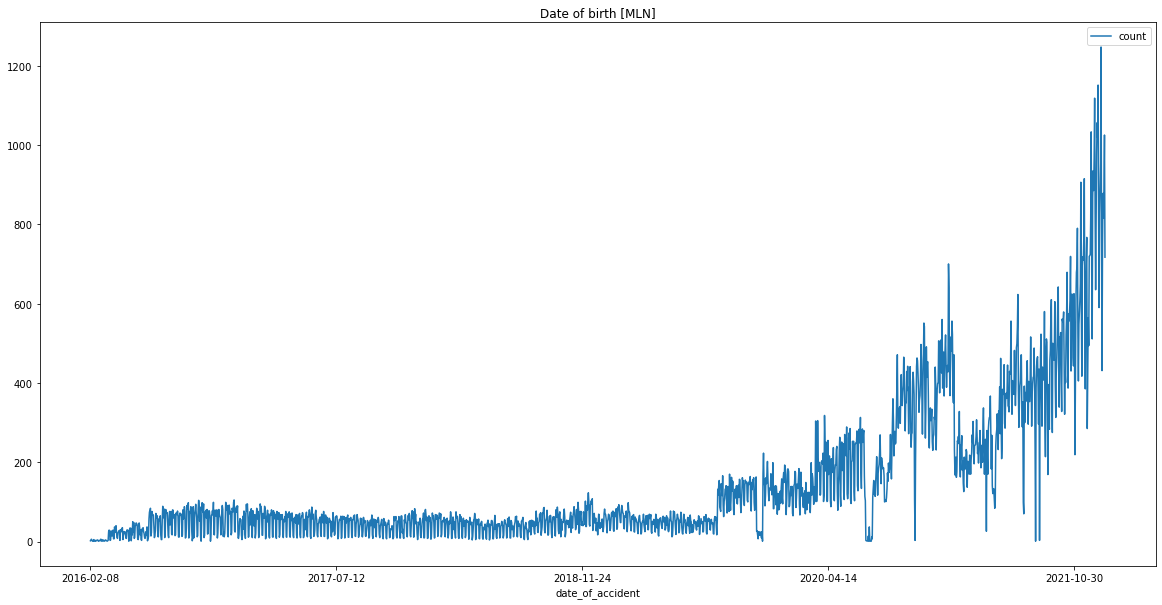

In [112]:
df_date = df.select('date_of_accident').groupBy('date_of_accident').count().orderBy('date_of_accident').toPandas()
df_date_chart = df_date.plot.line(title = 'Date of birth [MLN]', x='date_of_accident', figsize= (20,10))

# After initial analysis lets try to predict the value of accidents for the next day based on the weather conditions etc.